In [11]:
# General imports and widgets
import os
if os.getcwd().split('/')[-1] != 'deepARTransit':
    os.chdir('../..')
import sys
import warnings
import numpy as np
import matplotlib.pylab as plt
from pixlc import plotting
import ipywidgets as widgets
from ipywidgets import interactive
from utils.transit import LinearTransit
from pixlc.plotting import plot_mozaic

plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['font.size'] = 15
warnings.simplefilter("ignore")

# Project dir selection widget

project_button = widgets.Dropdown(
    options=[os.path.join('.'), # local git repo
             os.path.join('/','Users','Mario','mount_test','deepARTransit') # cobweb         
],
    #value=experiment_folder,
    # rows=10,
    description='\t\t',
    disabled=False
)

In [58]:
#project directory for loading the data
project_button

Dropdown(description='\t\t', options=('.', '/Users/Mario/mount_test/deepARTransit'), value='.')

In [3]:
# Experiment selection widget
project_dir = project_button.value

experiment_button = widgets.Dropdown(
    options=sorted(list({r.split('experiments')[1][1:] for r,d,f in os.walk(os.path.join(project_dir, 'deepartransit','experiments')) if 'output' in d and 'summary' in d})),
    #value=experiment_folder,
    # rows=10,
    description='\t\t',
    disabled=False
)

In [4]:
#Select an experime
experiment_button

Dropdown(description='\t\t', options=('cobweb/agol_rlc_r2/22807296', 'cobweb/agol_rlc_r2/22807808', 'cobweb/ag…

In [83]:
from utils.config import get_config_file, process_config
from deepartransit.data_handling import data_generator

experiment_folder = experiment_button.value
#experiment_folder = 'cobweb/agol_rlc/22807296/'
experiment_dir = os.path.join(project_dir, 'deepartransit', 'experiments', experiment_folder)
print(experiment_dir)
config_file = get_config_file(experiment_dir)
config = process_config(config_file)
data = data_generator.DataGenerator(config)
config = data.update_config()
width = int(np.sqrt(data.Z.shape[0]))

#os.listdir(os.path.join(project_dir, config.output_dir))

/Users/Mario/mount_test/deepARTransit/deepartransit/experiments/cobweb/deeparsys_pixels
loading data from deepartransit/data/plc_22807808_T.npy
(1, 690, 25) (1, 690, 2)
time_path parameter not found in config. Default to 0,1,2....T-1
Inferring num_features, num_cov, num_ts, batch_size from the data.


In [84]:
d = {}
for fn in [s for s in os.listdir(os.path.join(project_dir, config.output_dir)) if (s[:3] == 'loc')]:
    step = fn.split('_')[-1].split('.')[0]
    try:
        d[int(step)] = np.load(os.path.join(project_dir, config.output_dir, fn))#.mean(axis=0)
        #pred_instr = traces_array.mean(axis=(0))
        #length_pred = pred_instr.shape[1]
        #plc_trans = data.Z[:, config.pretrans_length:config.pretrans_length+config.trans_length+1]
    except:
        print(fn)
        continue
step_list = sorted([int(k) for k in d if k!='array'])
print(step_list)

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000]


In [85]:
# Visualize evolution of predictions and fits


pred_range = range(config.pretrans_length, config.pretrans_length+ config.trans_length + 1)

def update(step = step_list[-1]):
    loc_k = np.load(os.path.join(project_dir, config.output_dir, 'loc_array_{}.npy'.format(step))).flatten()
    
    t_c, delta, T, tau = np.load(os.path.join(project_dir, config.output_dir, 'trans_pars_{}.npy'.format(step)))
    transit = LinearTransit(data.time_array, [t_c, delta, T, tau])
    
    scales_k = np.load(os.path.join(project_dir, config.output_dir, 'scales_array_{}.npy'.format(step))).flatten()
    plt.plot(data.Z.flatten())
    plt.plot()
    p = plt.plot(loc_k)
    plt.fill_between(data.time_array, loc_k - 2 * scales_k, loc_k + 2* scales_k, alpha= 0.3, color=p[0].get_color())
    #plt.plot(pred_range, d[step][:,0,:,0].T, label=step, color='grey', linewidth=0.2, alpha= 0.3)
    #plt.plot(pred_range, d[step][:,0,:,0].mean(0), label=step, color='red', linewidth=1)
    #plt.plot(pred_range, data.scaler_Z.transform(data.scaler_Z.inverse_transform(d[step][:,0,:,0].mean(0)) *
    #                                             transit.flux[pred_range]).flatten(), 
    #         label=step, color='red', linewidth=1, alpha=0.7)
    
    print('transit params: {}'.format([t_c, delta, T, tau]))
    plt.title('step {}'.format(step))
    plt.show()
    plt.plot(data.scaler_Z.inverse_transform(data.Z).flatten()/
             data.scaler_Z.inverse_transform(loc_k).flatten())
    plt.plot(transit.flux, color='red')
    plt.show()
    
def update_pixels(step = step_list[-1]):
    loc_k = np.load(os.path.join(project_dir, config.output_dir, 'loc_array_{}.npy'.format(step))).swapaxes(0,1)

    t_c, delta, T, tau = np.load(os.path.join(project_dir, config.output_dir, 'trans_pars_{}.npy'.format(step)))
    transit = LinearTransit(data.time_array, [t_c, delta, T, tau])
    print('transit params: {}'.format([t_c, delta, T, tau]))
    scales_k = np.load(os.path.join(project_dir, config.output_dir, 'scales_array_{}.npy'.format(step))).swapaxes(0,1)
    grid = plot_mozaic(data.Z.reshape(-1, 5, 5), label='data')
    plot_mozaic(loc_k.reshape(-1, 5, 5), label='pred', grid=grid)
    plt.show()
    
    plt.plot(data.Z.sum(axis=(0, -1)))
    plt.plot(loc_k.sum(axis=(0, -1)))
    plt.show()
    plt.plot(data.scaler_Z.inverse_transform(data.Z).sum((0,-1))/
         data.scaler_Z.inverse_transform(loc_k).sum((0,-1)))
    plt.plot(transit.flux, color='red')
    plt.show()

if config.num_features - 1:  # Pixels mode
    interactive_plot = interactive(update_pixels, step=(step_list[0], step_list[-1], config.freq_eval))
    output = interactive_plot.children[-1]
    output.layout.height = '1200px'
else:
    interactive_plot = interactive(update, step=(step_list[0], step_list[-1], config.freq_eval))
    output = interactive_plot.children[-1]
    output.layout.height = '800px'

interactive_plot

interactive(children=(IntSlider(value=2000, description='step', max=2000, min=50, step=50), Output(layout=Layo…

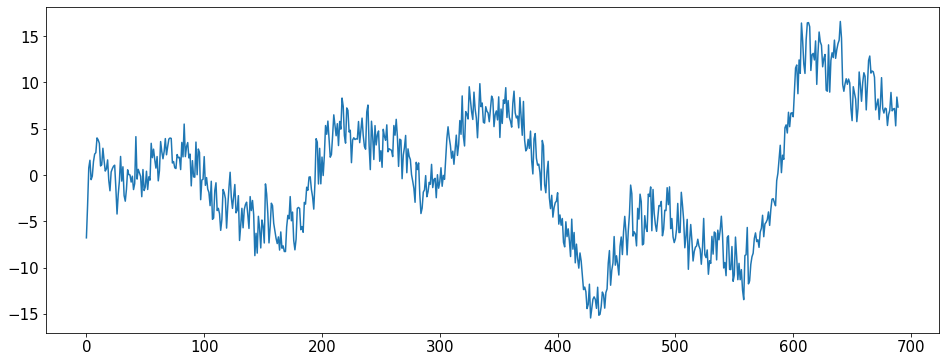

In [90]:
plt.plot(data.Z.sum((0,-1)))
plt.plot(data.Z.sum((0,-1)))